# Predicting Employee Attrition Using Decision Trees and Random Forests

## Data Preprocessing

In [131]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc
from sklearn.metrics import plot_confusion_matrix

# loading in csv and looking at first 5 rows
df = pd.read_csv("../Data/WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.head()

# setting seed variable
seed = 13

In [132]:
# only keep columns we want to use as features for prediction
df = df[['Age', 'Attrition', 'Education', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MonthlyIncome', 'PerformanceRating', 'WorkLifeBalance', 'YearsAtCompany', 'YearsSinceLastPromotion']]
df.shape

(1470, 14)

In [133]:
# remove any rows that have at least one null or missing value
df.dropna()
df.shape

# no rows were dropped - all rows have complete data

(1470, 14)

In [134]:
# encode values that are not binary or discrete
# encode Attrition (target variable)
# 1 = yes, 0 = no
attrition_encoder = LabelEncoder()
attrition_encoder.fit(df['Attrition'])
attrition_vals = attrition_encoder.transform(df['Attrition'])
attrition_df = pd.DataFrame(attrition_vals, columns=['Attrition'])

# encode Gender
# 1 = male, 0 = female
gender_encoder = LabelEncoder()
gender_encoder.fit(df['Gender'])
gender_vals = gender_encoder.transform(df['Gender'])
gender_df = pd.DataFrame(gender_vals, columns=['Gender'])

# encode JobRole
job_role_encoder = LabelEncoder()
job_role_encoder.fit(df['JobRole'])
job_role_vals = job_role_encoder.transform(df['JobRole'])
job_role_df = pd.DataFrame(job_role_vals, columns=['JobRole'])
print(list(df['JobRole'].unique()))
print(job_role_vals)

['Sales Executive', 'Research Scientist', 'Laboratory Technician', 'Manufacturing Director', 'Healthcare Representative', 'Manager', 'Sales Representative', 'Research Director', 'Human Resources']
[7 6 2 ... 4 7 2]


In [135]:
df['AttritionEncoded'] = attrition_df
df['GenderEncoded'] = gender_df
df['JobRoleEncoded'] = job_role_df

# job role encodings table - just for readability
table_df = pd.DataFrame()
table_df['JobRole'] = df['JobRole'].unique()
table_df['Encoding'] = df['JobRoleEncoded'].unique()
table_df

,JobRole,Encoding
0,Sales Executive,7
1,Research Scientist,6
2,Laboratory Technician,2
3,Manufacturing Director,4
4,Healthcare Representative,0
5,Manager,3
6,Sales Representative,8
7,Research Director,5
8,Human Resources,1


In [136]:
# drop non-encoded columns
df = df.drop(["Attrition", "Gender", "JobRole"], axis = 1)
df.columns

Index(['Age', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement',
       'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'PerformanceRating',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'AttritionEncoded', 'GenderEncoded', 'JobRoleEncoded'],
      dtype='object')

## Predicting Employee Attrition Decision Trees

In [137]:
# statistics regarding attrition (target value) 

# 1470 rows total - find percentage of employees who left / didn't leave
# number of employees that left
percent_left = ((df['AttritionEncoded'] == 1).sum()) / df['AttritionEncoded'].count()

# number of employees that stayed
percent_stayed = ((df['AttritionEncoded'] == 0).sum()) / df['AttritionEncoded'].count()

print('Percentage of employees who left: {}%'.format((round(percent_left * 100, 2))))
print('Percentage of employees who left: {}%'.format((round(percent_stayed * 100, 2))))

# will have to address class imabalance when tuning model

Percentage of employees who left: 16.12%
Percentage of employees who left: 83.88%


In [150]:
# splitting target and feature variables
y = df['AttritionEncoded']
X = df.drop(columns = ['AttritionEncoded'], axis = 1)

# creating train / test split
# random_state = 13 (my favorite number)
# leaving default of test_size = .25, train_size = .75
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13)

In [151]:
# class imbalance in train / test data
# training data
print("Training data:")
print(y_train.value_counts())

# testing data
print("\nTesting data:")
print(y_test.value_counts())

Training data:
0    923
1    179
Name: AttritionEncoded, dtype: int64

Testing data:
0    310
1     58
Name: AttritionEncoded, dtype: int64


### Creating the Initial Decision Tree Model

In [152]:
# training classifier object
attrition_classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = seed)
attrition_classifier.fit(X_train, y_train)

# make predicitons
y_predict = attrition_classifier.predict(X_test)

### Checking Performance

Confusion Matrix:


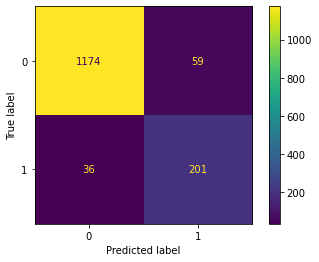

Accuracy: 74.18478260869566
Precision 0.2716049382716049
AUC: 0.5944938820912126


In [153]:
# ignoring deprecation warning for plot_confusion_matrix
import warnings
warnings.simplefilter('ignore')

# confusion matrix
print("Confusion Matrix:")
plot_confusion_matrix(attrition_classifier, X, y)
plt.show()

# measuring accuracy
accuracy = accuracy_score(y_test, y_predict) * 100
print("Accuracy:", accuracy)

# measuring precision
precision = precision_score(y_test, y_predict)
print("Precision", precision) # want a value close to 1

# measuring AUC (Area Under the ROC Curve)
false_pos, true_pos, thresholds = roc_curve(y_test, y_predict)
area_under_roc = auc(false_pos, true_pos)
print("AUC:", area_under_roc) # .56 is pretty close to just random guessing

Right now, model is sort of accurate but not precise. Also model is barely better than randomly guessing if an employee will leave or not (AUC score = .56).

# Might need to prune model - look into it

### Max Depth

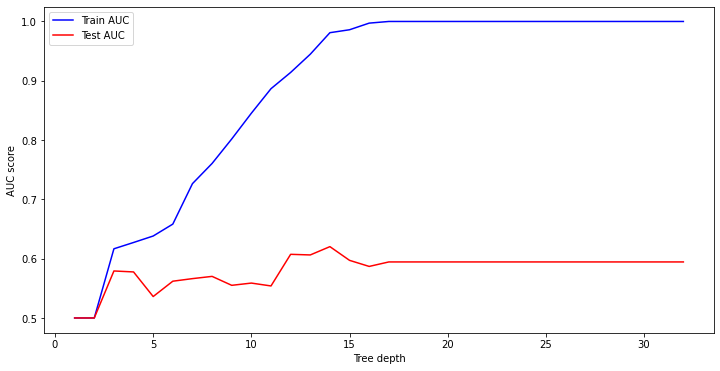

In [154]:
# hyperparameter tuning / pruning
# max depth - code from hyperparameter lab
max_depths = list(range(1, 33))
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=seed)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_depths, train_results, 'b', label='Train AUC')
plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.legend()
plt.show()

Optimal depth for this tree is 2

### Minimum Sample Split

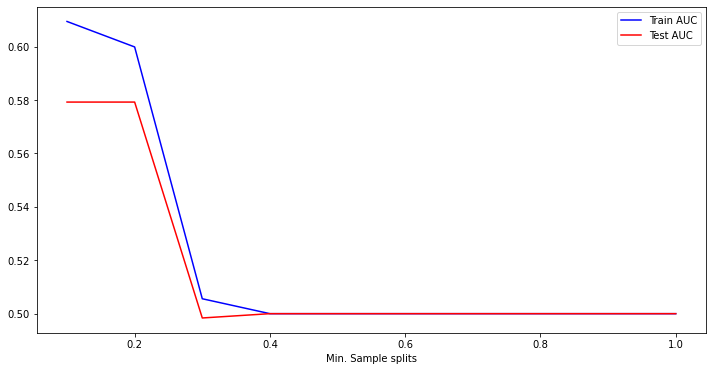

In [155]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=min_samples_split, random_state=seed)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(min_samples_splits, train_results, 'b', label='Train AUC')
plt.plot(min_samples_splits, test_results, 'r', label='Test AUC')
plt.xlabel('Min. Sample splits')
plt.legend()
plt.show()

0.4 for minimum sample split

### Minimum Sample Leafs

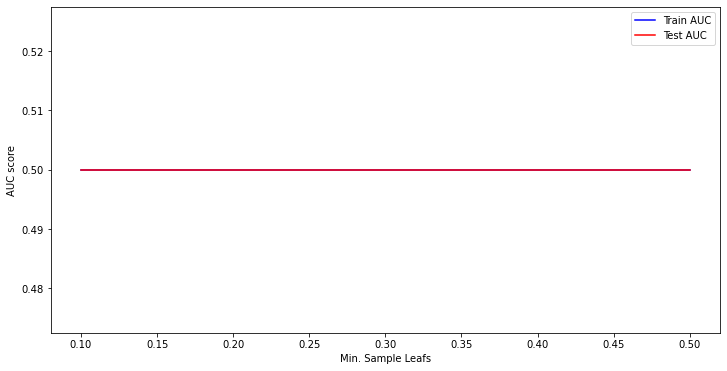

In [156]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=min_samples_leaf, random_state=seed)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
plt.figure(figsize=(12,6))    
plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('Min. Sample Leafs')
plt.legend()
plt.show()

No good value here I guess?

### Maximum Features

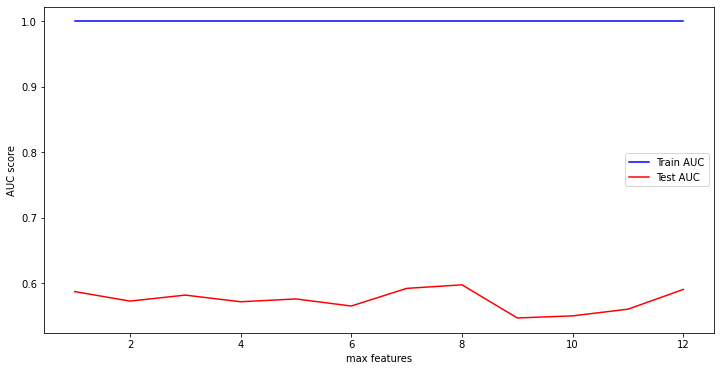

In [157]:
max_features = list(range(1, X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
    dt = DecisionTreeClassifier(criterion='entropy', max_features=max_feature, random_state=seed)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

plt.figure(figsize=(12,6))
plt.plot(max_features, train_results, 'b', label='Train AUC')
plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.legend()
plt.show()

best is when max features = 8 I guess?

In [164]:
# retrain model based on all of these things
dt = DecisionTreeClassifier(criterion='entropy',
                           max_features=8,
                           max_depth=2,
                           min_samples_split=0.4,
                           min_samples_leaf=0.25
                           random_state=seed)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

SyntaxError: invalid syntax (1845502610.py, line 7)

Confusion Matrix:


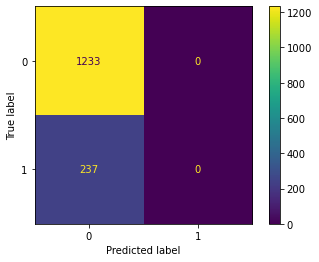

Accuracy: 84.23913043478261
Precision 0.0
AUC: 0.5


In [165]:
# ignoring deprecation warning for plot_confusion_matrix
import warnings
warnings.simplefilter('ignore')

# confusion matrix
print("Confusion Matrix:")
plot_confusion_matrix(dt, X, y)
plt.show()

# measuring accuracy
accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy:", accuracy)

# measuring precision
precision = precision_score(y_test, y_pred)
print("Precision", precision) # want a value close to 1

# measuring AUC (Area Under the ROC Curve)
false_pos, true_pos, thresholds = roc_curve(y_test, y_pred)
area_under_roc = auc(false_pos, true_pos)
print("AUC:", area_under_roc) # .56 is pretty close to just random guessing

### Addressing Class Imbalance

#### Tuning the Decision Tree Model

In [105]:
# had to install imblearn
!pip install imblearn

  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0


In [114]:
# using SMOTE to resample data
from imblearn.over_sampling import SMOTE

print("Classifications BEFORE Resample:")
print(y_train.value_counts())

X_train_resample, y_train_resample = SMOTE().fit_resample(X_train, y_train)

# should have same number of each classification
print("\nClassifications AFTER Resample:")
print(pd.Series(y_train_resample).value_counts())

Classifications BEFORE Resample:
0    923
1    179
Name: AttritionEncoded, dtype: int64

Classifications AFTER Resample:
0    923
1    923
Name: AttritionEncoded, dtype: int64


#### Building Model with Resampled Data

In [126]:
# training classifier object
attrition_classifier_resample = DecisionTreeClassifier(criterion = 'entropy', random_state = 13)
attrition_classifier_resample.fit(X_train_resample, y_train_resample)

# make predicitons
y_predict_resample = attrition_classifier_resample.predict(X_test)

Confusion Matrix:


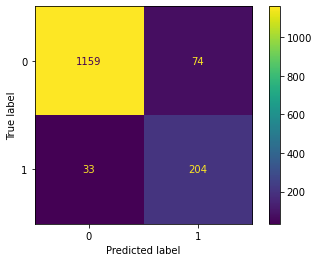

Accuracy: 70.92391304347827
Precision 0.25252525252525254
AUC: 0.5944938820912126


In [127]:
# ignoring deprecation warning for plot_confusion_matrix
import warnings
warnings.simplefilter('ignore')

# confusion matrix
print("Confusion Matrix:")
plot_confusion_matrix(attrition_classifier_resample, X, y)
plt.show()

# measuring accuracy
accuracy_resample = accuracy_score(y_test, y_predict_resample) * 100
print("Accuracy:", accuracy_resample)

# measuring precision
precision_resample = precision_score(y_test, y_predict_resample)
print("Precision", precision_resample) # want a value close to 1

# measuring AUC (Area Under the ROC Curve)
false_pos_resample, true_pos_resample, thresholds_resample = roc_curve(y_test, y_predict_resample)
area_under_roc_resample = auc(false_pos, true_pos)
print("AUC:", area_under_roc_resample) # .56 is pretty close to just random guessing

## Predicting Employee Attrition with Random Forests